# MEDIDAS COM VNA

In [2]:
#Header notebook
data_exp={
    "Responsible":"Daniel G. Benvenutti",
    "setup":"VNA on the Cavity",
    "sample":"2QTII",
}

## SETUP

### Importar drivers

 Os drivers estão todos localizados na pasta Instruments

In [1]:
# drivers de controle dos instrumentos
from instruments.E5063A_driver import *  # VNA
from instruments.Agilent11713C_driver import *  # attenuator
from instruments.E8257D_driver import *  # RF source

### Outras bibliotecas para ajudar na medida

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from time import sleep
from IPython.display import clear_output
from datetime import datetime
from tqdm.notebook import tqdm

### Configura os outros Instrumentos

In [4]:
att_address = "TCPIP0::169.254.101.101::inst0::INSTR"
RFsourceMeasurement_address = "TCPIP0::169.254.101.103::inst0::INSTR"
RFsourceExcitation_address = "TCPIP0::169.254.101.104::inst0::INSTR"

vna = E5063A_driver("TCPIP0::169.254.101.105::inst0::INSTR")
inst_att = Agilent11713C_driver(att_address)
# inst_RFsourceMeasurement = E8257D_driver(RFsourceMeasurement_address)
inst_RFsourceExcitation = E8257D_driver(RFsourceExcitation_address)

In [5]:
# A fonte de excitação recebe o canal 3 - marker 1 -  normal
inst_RFsourceExcitation.set_pulse_trigger_external()
inst_RFsourceExcitation.setPulsePolarityNormal()
inst_RFsourceExcitation.start_mod()

# A fonte de excitação não é necessariamente usada no processo de medida da cavidade (a menos que se queira ver os deslocamento dispersivo de frequência)
# no caso sua amplitude é por volta de 11 dBm
inst_RFsourceExcitation.set_amplitude(11)

In [6]:
# parar as fontes
inst_RFsourceExcitation.stop_rf()

## PUNCHOUT

In [7]:
inst_att.set_attenuation(50)

In [18]:
start = 7.018 * 1e9
stop = 7.022 * 1e9
f_c = (stop + start) / 2
span_f = stop - start
n_pontos = 600
if_bandwidth = 700
sleepp = 5


vna.power = 0
vna.data_array_format = "MLOG"
vna.clear_averaging()

vna.average_points = 128
vna.averaging = 1
# NA.set_amplitude(power)

vna.center_frequency = f_c
vna.span_frequency = span_f
vna.if_bandwidth_frequency = if_bandwidth
vna.sweep_points = n_pontos
vna.autoscale(0)

vna.power = 1

sleep(sleepp)

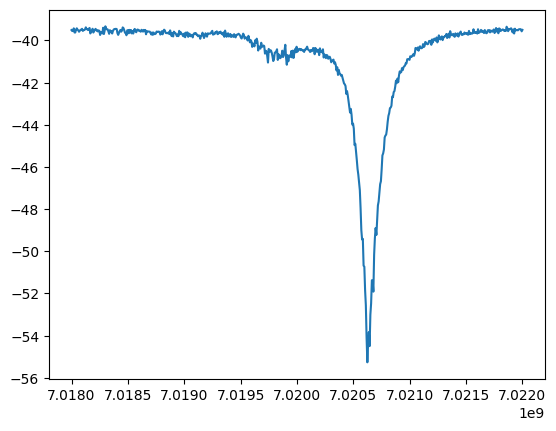

magmin freq= 7020624373.96


In [19]:
mags = np.array([])

clear_output(wait=True)
# Esse comando muda a atenuação do switch
# att.attenuation = 10

# Reseta as medidas
# NA.clear_averaging()
# time.sleep(15) #800

# Esse comando captura os dados do NA e formata em array numpy de floats
str_data = vna.data_array()
data = np.array(str_data.split(","), "float")
str_freqs = vna.frequency_array()
Freq = np.array(str_freqs.split(","), "float")
mags = np.append(mags, data[0::2])

#matplotlib
#plt.plot(Freq, mags.T)
#plt.xlabel("Frequency (Hz)")
#plt.ylabel("Magnitude (dBm)")
#plt.title("Punchout")
#plt.pause(0.05)
#plt.show()
#plotly
px.line(x=Freq,y=mags.T,width=600,height=600).show()

print("magmin freq=", Freq[np.argmin(mags.T)])

In [16]:
mags0 = mags

In [20]:
mags1 = mags

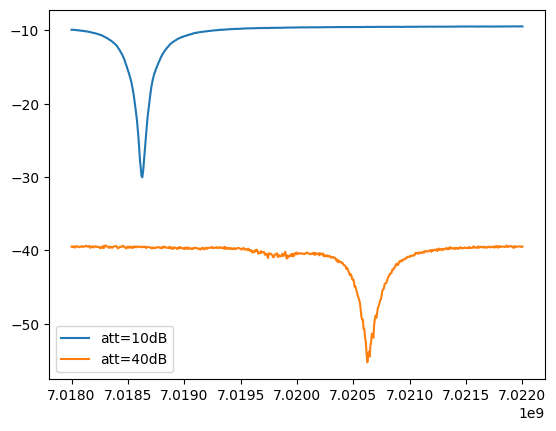

magmin att=40dB freq= 7018627712.85
magmin att=0dB freq= 7020624373.96


In [22]:
plt.plot(Freq, mags0.T, label="att=10dB")
plt.plot(Freq, mags1.T, label="att=40dB")
plt.legend()
plt.show()
go.Figure()
print("magmin att=40dB freq=", Freq[np.argmin(mags0.T)])
print("magmin att=0dB freq=", Freq[np.argmin(mags1.T)])

## PowerSweep

In [30]:
# EXPERIMENT PARAMETERS

parameters = {
    "name": "PowerSweep",
    "if_bandwidth": 500,
    "Freq": np.linspace(7.018e9, 7.0215e9, 1000), #Hz
    "Att": np.arange(5, 60, 1), #dB
    "vna_avg_points": 512,
    "vna_averaging": 1,
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}
parameters

{'if_bandwidth': 500,
 'Responsavel': 'Daniel G. Benvenutti',
 'setup': 'VNA',
 'amostra': '2QTII'}

In [ ]:
start = parameters["Freq"][0]
stop = parameters["Freq"][-1]
n_freqs = len(parameters["Freq"])
if_bandwidth = parameters["if_bandwidth"]

f_c = (stop + start) / 2
span_f = stop - start

Freq = parameters["Freq"]
Att = parameters["Att"]


vna.power = 0
vna.data_array_format = "MLOG"
vna.clear_averaging()

vna.average_points = parameters["vna_avg_points"]
vna.averaging = parameters["vna_averaging"]
# NA.set_amplitude(power)

vna.center_frequency = f_c
vna.span_frequency = span_f
vna.if_bandwidth_frequency = if_bandwidth
vna.sweep_points = n_freqs
vna.autoscale(1)

vna.power = 1

# queries vna until it's not busy
vna.query("*OPC?")

#### Tempo para o VNA terminar as medias (sweeptime*n_medias)
Usar como referência para ajustar o sleep time do loop

In [ ]:
sweep_time = vna.sweep_time
avg_points = vna.average_points
avging_time = avg_points * sweep_time
print(
    "sweeptime=",
    sweep_time,
    "s \navg_points=",
    avg_points,
    "\nVNA total averaging sleep time=",
    avging_time,
    "s",
)

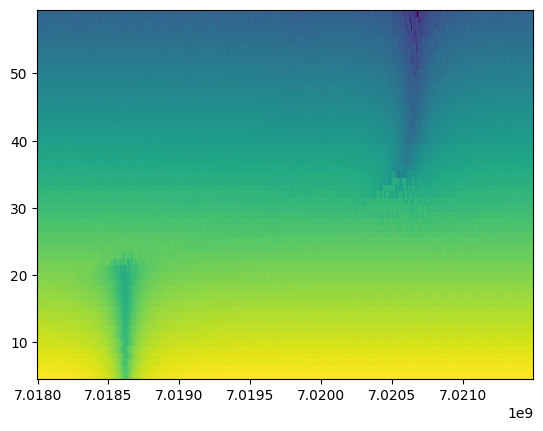

PowerSweep_Q3TII__2024_10_02__15_14_28


In [25]:
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{parameters["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")

howtoplot = (
    "\
    data = np.load('"
    + name
    + ".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"
)

Mag = np.full((len(Att), len(Freq)),np.nan)  # [[] for _ in range(len(freqs))]
Phase = np.full((len(Att), len(Freq)),np.nan)  # [[] for _ in range(len(freqs))]

#progress bar
pbar=tqdm(total=len(Att))
# Loop de Medidas
for j, att in enumerate(Att):
    inst_att.set_attenuation(att)
    inst_att.query('*OPC?')
    vna.clear_averaging()

    # queries vna and attenuator until theyre not busy
    # avging_time=vna.average_points*vna.sweep_time()
    # vna.query('*OPC?')
    
    # print(avging_time)
    # sleep(avging_time) # tempo para VNA fazer varias medias
    sleep(2)

    # Limpa o gráfico atual
    # plt.gcf().clear()
    clear_output(wait=True)

    # Esse comando captura os dados do NA e formata em array numpy de floats
    str_data = vna.data_array()
    data = np.array(str_data.split(","), "float")

    # mags = data[0::2]
    mags = data[::2]  # slices vector in 2 by 2 steps

    Mag[j][:] = mags
    print(name)
    pbar.update(1)
    display(pbar.container)

    #matplotlib
    #plt.xlabel("Frequency (Hz)")
    #plt.ylabel("Attenuation (dB)")
    #plt.title(name)
    #plt.pcolor(Freq, Att, Mag)
    #plt.pause(0.05)
    
    #plotly
    px.imshow(Mag,x=Freq,y=Att,aspect="auto",width=600,height=500).show()
    # plt.show()
    end=datetime.now()
    np.savez(name, header=howtoplot,  Mag=Mag, Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
    



In [ ]:
dados = np.load("PowerSweep_Q2TII__2024_10_02__15_14_28.npz")
dados["header"]
attenuations = dados["Att"]
Freq = dados["Freq"]
mags = dados["Mag"]
phases = dados["Phase"]
#print("start=",dados["start"].item()," end=",dados["end"].item())
plt.pcolor(Freq, attenuations, mags)

fmin= 7.0206635 GHz


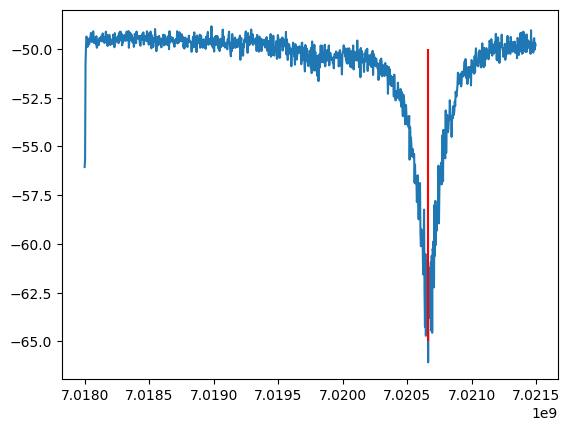

In [65]:
iatt=np.where(attenuations == 50)
iatt=iatt[0][0]
plt.plot(Freq, mags[iatt, :])
f=Freq[np.argmin(mags[iatt, :])]
print("fmin=",f/1e9,"GHz")
plt.vlines(f,-65,-50,color="red")

## TWOTONE

### Unique excitation amplitude

Tempo para o VNA terminar as medias (sweeptime*n_medias)

In [49]:
sweep_time=vna.sweep_time
avg_points=vna.average_points
avging_time =  avg_points* sweep_time
print("sweeptime=",sweep_time,"s \navg_points=",avg_points,"\nVNA total averaging sleep time=", avging_time,"s")

sweeptime= 0.0011722 s 
avg_points= 500 
VNA total averaging sleep time= 0.5861 s


In [ ]:
#EXPERIMENT PARAMETERS
parameters={
    "name":"TWOTONE_SWEEP",
   "attenuation":50, 
   "excitation_amp":-10,
   "Freq":np.arange(4000, 4470, 2) * 1e6,#Hz
}

#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}
parameters

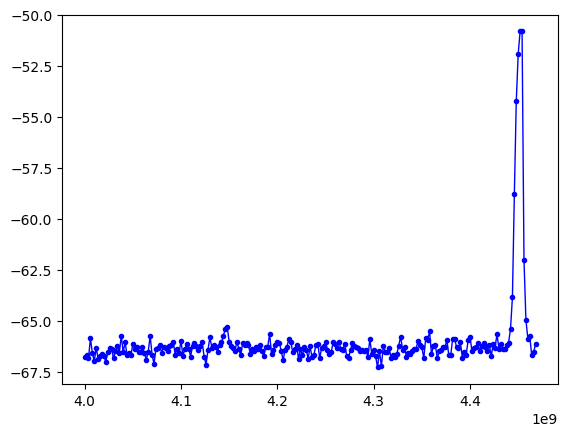

TWOTONE_SWEEP_Q2TII__2024_10_03__13_45_35


In [90]:
Freq = parameters["Freq"]
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{parameters["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = (
    "\
    data = np.load('"
    + name
    + ".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"
)



inst_att.set_attenuation(parameters["atenuattion"])
inst_RFsourceExcitation.set_amplitude(parameters["excitation_amp"])
inst_RFsourceExcitation.start_rf()


# cria vetores preechidos com Not A Number ("vazio")
Mag = np.full(len(Freq),np.nan)  # 
Phase = np.full(len(Freq),np.nan)  # 



str_data = vna.data_array()


vna.data_array_format = "PLOG"

#progress bar
pbar=tqdm(total=len(Freq))
# Loop de Medidas
for i, freq in enumerate(Freq):
    clear_output(wait=True)

    inst_RFsourceExcitation.set_frequency(freq)
    vna.clear_averaging()

    # queries vna and RF source until theyre not busy
    # vna.query('*OPC?')
    inst_RFsourceExcitation.query("*OPC?")
    sleep(0.6)  # mais que suficiente pq tem só 3 pontos

    str_data = vna.data_array()
    data = np.array(str_data.split(","), "float")

    mag = np.mean(data[::2])  # média dos 3 pontos setados no VNA
    phase = data[1::2][int(len(data[::2]) / 2)]

    Mag[i] = mag
    Phase[i] = phase

    # Limpa o gráfico atual

    clear_output(wait=True)
    print(name)
    pbar.update(1)
    display(pbar.container)
#matplotlib
    #plt.xlabel("Frequency (Hz)")
    #plt.ylabel("Magnitude (dBm)")
    #plt.title(name)
    #plt.plot(Freq, Mag, "bo-", linewidth=1, markersize=3)
    #plt.pause(0.05)
    #plt.xlim(Freq[0],Freq[-1])
    
    #plotly
    px.line(x=Freq,y=Mag,width=600,height=600).show()

    end=datetime.now()
    np.savez(name, header=howtoplot,  Mag=Mag, Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
inst_RFsourceExcitation.stop_rf()




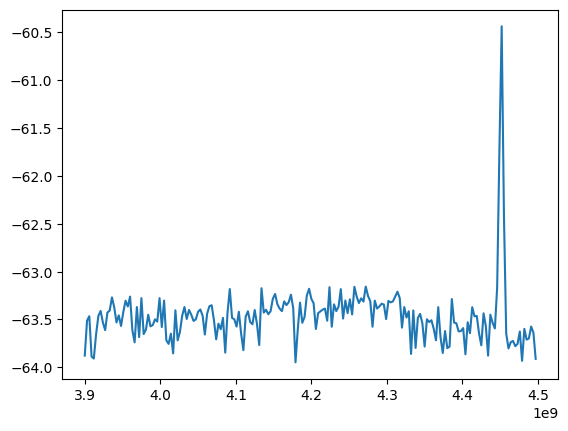

In [47]:
dados = np.load("TWOTONE_SWEEP_Q2TII__2024_10_02__17_39_40.npz")
dados["header"]
freqs = dados["Freq"]
mags = dados["Mag"]
phases = dados["Phase"]
plt.plot(freqs, mags)

### Map

In [ ]:
#VNA config optional
vna.center_frequency = 6.89685e9
vna.span_frequency = 1000
vna.if_bandwidth_frequency = 500
vna.sweep_points = 3
vna.average_points = 256
vna.averaging = 1
vna.power = 1

In [ ]:
#EXPERIMENT PARAMETERS
parameters={
    "name":"TWOTONE_MAP",
   "attenuation":50, 
   "Freq":np.arange(4100, 4470, 2) * 1e6, #Hz
   "Amp":np.arange(5, 18, 2),
}

#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}
parameters

In [50]:
sweep_time=vna.sweep_time
avg_points=vna.average_points
avging_time =  avg_points* sweep_time
print("sweeptime=",sweep_time,"s \navg_points=",avg_points,"\nVNA total averaging sleep time=", avging_time,"s")

sweeptime= 0.0011722 s 
avg_points= 500 
VNA total averaging sleep time= 0.5861 s


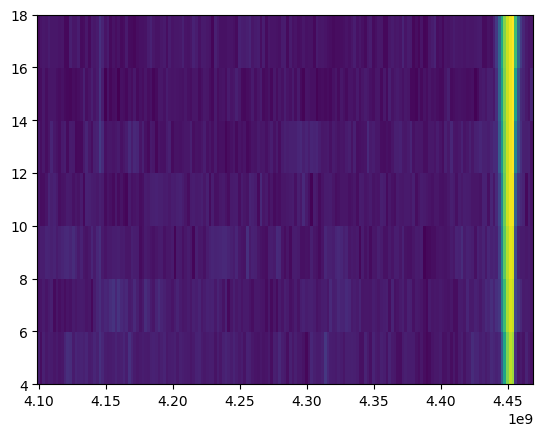

TWOTONE_MAP_Q2TII_2024_10_03__13_01_42


In [55]:
Freq = parameters["Freq"]
Amp = parameters["Amp"]

# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{parameters["name"]}_{data_exp["sample"]}_%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = (
    "\
    data = np.load('"
    + name
    + ".npz')\n\
    amplitudes = data['Amp']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"
)


inst_att.set_attenuation(parameters["attenuation"])


# set valores "vazios" (nan=not a number) para plot interativo
Mag = np.full((len(Amp), len(Freq)),np.nan)
Phase = np.full((len(Amp), len(Freq),np.nan))


str_data = vna.data_array()  # cria um array vazio


inst_RFsourceExcitation.start_rf()
vna.data_array_format = "PLOG"

#progress bar
pbar=tqdm(total=len(Amp)*len(Freq))
# Loop de Medidas
for j, amp in enumerate(Amp):
    inst_RFsourceExcitation.set_amplitude(amp)  # seta a amplitude atual do loop

    for i, freq in enumerate(Freq):
        clear_output(wait=True)  # limpa a saída

        inst_RFsourceExcitation.set_frequency(freq)  # seta a frequência atual do loop
        # queries RF source until its not busy
        inst_RFsourceExcitation.query("*OPC?")
        vna.clear_averaging()  # restarta a média
        
        #sleep(avging_time+0.1)
        sleep(0.6)  # tempo pra fazer as médias

        str_data = vna.data_array()  # pega os dados
        data = np.array(str_data.split(","), "float")  # separa os dados

        mag = np.mean(data[::2])
        phase = data[1::2][int(len(data[::2]) / 2)]

        Mag[j][i] = mag
        Phase[j][i] = phase

        # Limpa o gráfico atual
        # plt.gcf().clear()
        clear_output(wait=True)
        print(name)
        pbar.update(1)
        display(pbar.container)
        #matplotlib
        #plt.ylabel("Excitation amplitude (dBm)")
        #plt.xlabel("Frequency (Hz)")
        #plt.title(name)
        #plt.pcolor(Freq, Amp, Mag)
        #plt.pause(0.05)
        #plotly
        px.imshow(Mag,x=Freq,y=Amp,aspect="auto",width=600,height=500).show()

        end=datetime.now()
        np.savez(name, header=howtoplot, Amp=Amp, Freq=Freq, Mag=Mag, Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
inst_RFsourceExcitation.stop_rf()


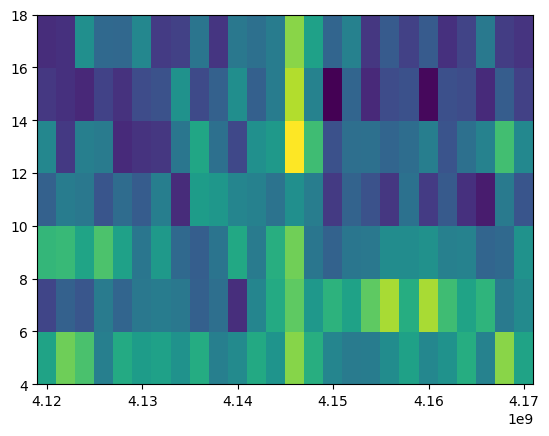

In [87]:
inds=np.where((Freq>=4.12e9) & (Freq<=4.17e9))
inds
plt.pcolor(Freq[inds[0]],Amp,Mag[:,inds[0]])

In [91]:
inst_RFsourceExcitation.stop_rf()